# Topic Modelling
- abstracts are to be tagged for descriptive analysis (ideally with the studied disease, cell type etc.)
- there are three typically used algorithms for topic modelling:
    - Latent Semantic Analysis (LSA)
    - Latent Dirichlet Allocation (LDA)
    - non-negative matrix factorization (NMF)
- for LSA it's difficult to distinguish between the different meanings of one word, which is why LSA will only be tried if there is time remaining
- LDA is able to recognize synonyms and distingiush between the different meanings of a word
- NMF has already been used to 'tag' abstracts (Nielsen *et al.* 2005, https://www.ncbi.nlm.nih.gov/pubmed/15946864)

In [1]:
import pandas as pd
import numpy as np

# Imports for word cloud
from wordcloud import WordCloud
import PIL
import itertools
import matplotlib.pyplot as plt


import nltk
from gensim import corpora, models
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from gensim import similarities
import re

[nltk_data] Downloading package stopwords to /Users/kaddi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('../data/cleaned_abstracts.csv', index_col=0)
df = pd.read_csv('../data/original_df.csv', index_col=0)

In [3]:
data.head()

,abstract
0,Bone. 2018 Sep 24. pii: S8756-3282(18)30355-7....
1,Neurosci Lett. 2018 Sep 24. pii: S0304-3940(18...
2,Antivir Ther. 2018 Sep 27. doi: 10.3851/IMP326...
3,Fetal Pediatr Pathol. 2018 Sep 27:1-11. doi: 1...
4,Clin Exp Immunol. 2018 Oct;194(1):17-26. doi: ...


In [4]:
text = data['abstract']

### Replacing of 'short names' with 'actual names'
- to ensure that the different forms of vitamin D are recognised properly by the algorithm, the short version with numbers are replaced with the actual names
    - the different writing styles are checkt via str.extract and used for filter buiding
    - the efficiency of the filter is checked by counting the occurrences of 1,25 and 25-
- since the 'd' of 'vitamin d' is so short, it is always removed, this is why the 'd' is fused to the 'vitamin'

In [5]:
def easy_words(column):
    text = column.str.lower()
    
    text = text.str.replace('1,25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25\S+ vit d', 'calcitriol')
    text = text.str.replace('1,25\S+', 'calcitriol')

    text = text.str.replace('1,25 vitamin d', 'calcitriol')
    text = text.str.replace('1,25 vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ d', 'calcitriol')
    text = text.str.replace('1,25 \S+', 'calcitriol')
    
    text = text.str.replace('25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('25\S+ vit d', 'calcitriol')
    text = text.str.replace('25\S+', 'calcitriol')
 
    text = text.str.replace('vitamin d', 'vitamind')
    text = text.str.replace('vit d', 'vitamind')
    
    text = text.str.replace('tb', 'tuberculosis')
    
    return text

In [6]:
text = easy_words(text)

In [7]:
list_125 = text.str.extract('(1,25)')
list_125[list_125[0].str.contains('NaN') == False].count()

0    0
dtype: int64

In [8]:
list_25 = text.str.extract('(25-)')
list_25[list_25[0].str.contains('NaN') == False].count()

0    0
dtype: int64

In [9]:
list_tb = text.str.extract('(tb)')
list_tb[list_tb[0].str.contains('NaN') == False].count()

0    0
dtype: int64

All occurrences of the short names could be replaced with their long versions.

### Word Clouds
- to evaluate the most prominent words in an abstract, word clouds are used
- aim: to improve the stopword list with science/medical specific terms

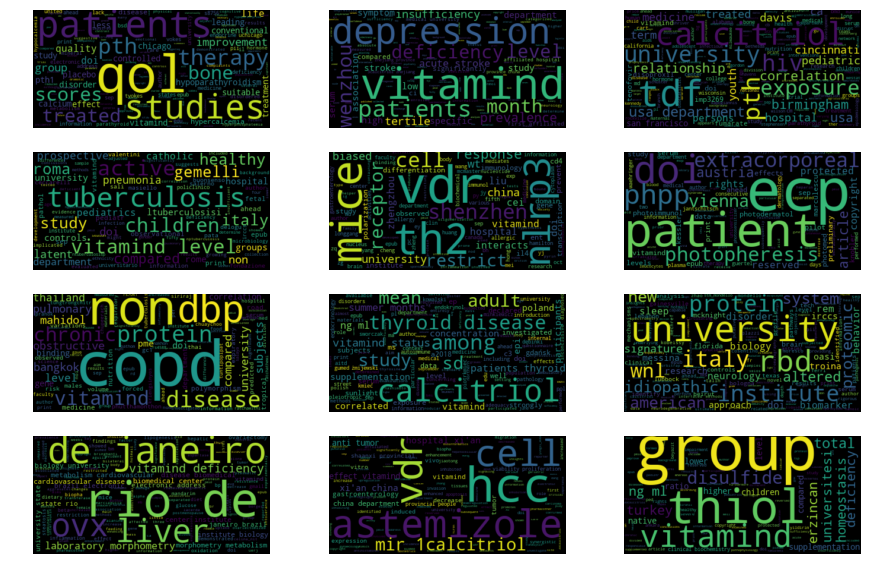

In [10]:
plt.figure(1, figsize=(15,10))

for entry in range(0,12):
    raw_str = text.iloc[entry]
    wordcloud = WordCloud(max_words=1000,margin=0).generate(raw_str)
    
    plt.subplot(4,3, 1 + entry)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.show()

The most used words in the abstracts are often not very descriptive (e.g. rio de janeiro, university, patient, vitamind)

### MVP: LDA
- for the MVP all of the abstract is used to determine a topic
- the abstract is not formatted in any way, except for the easy_words function, the removal of non-letter characters and the splitting in single words

In [11]:
NUM_TOPICS_abstracts =10
STOPWORDS = stopwords.words('english')

In [12]:
split_text = text.str.split()

In [13]:
clean_text = []

for entry in range(0,len(split_text)):
    clean_text.append([word for word in split_text.iloc[entry] if word not in
                       STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}',
                                              word)])

In [14]:
dictionary_abstracts = corpora.Dictionary(clean_text)
print(dictionary_abstracts)

Dictionary(390498 unique tokens: ['addition,', 'address:', 'adequately', 'adjunct', 'ahead']...)


In [15]:
corpus_abstracts = [dictionary_abstracts.doc2bow(text) for text in clean_text]

In [16]:
# Build LDA model
lda_model = models.LdaModel(corpus=corpus_abstracts, num_topics=NUM_TOPICS_abstracts, 
                            id2word=dictionary_abstracts)

In [17]:
for idx in range(NUM_TOPICS_abstracts):
    print("Topics #%s:" % idx, lda_model.print_topic(idx, 3))

Topics #0: 0.041*"bone" + 0.028*"calcium" + 0.012*"patients"
Topics #1: 0.038*"rats" + 0.012*"rats." + 0.007*"vitamind"
Topics #2: 0.015*"bile" + 0.010*"calcitriol" + 0.009*"liver"
Topics #3: 0.010*"van" + 0.007*"heart" + 0.006*"aluminium"
Topics #4: 0.007*"crystalline" + 0.007*"muscle" + 0.005*"chondroitin"
Topics #5: 0.050*"calcitriol" + 0.035*"serum" + 0.026*"vitamind"
Topics #6: 0.028*"vitamind" + 0.010*"may" + 0.009*"pmid:"
Topics #7: 0.025*"patients" + 0.013*"treatment" + 0.013*"renal"
Topics #8: 0.028*"calcitriol" + 0.012*"cells" + 0.009*"cell"
Topics #9: 0.016*"vitamin" + 0.014*"dietary" + 0.012*"diet"


Unclean text is chosen as topic (e.g. 'pmid:' or 'medline]') and the topics are very general in their description.

### Improving the topic modeling with LDA
- maybe using the headlines will give more descriptive topics

In [18]:
titles = easy_words(df['title'])
titles = titles.dropna()

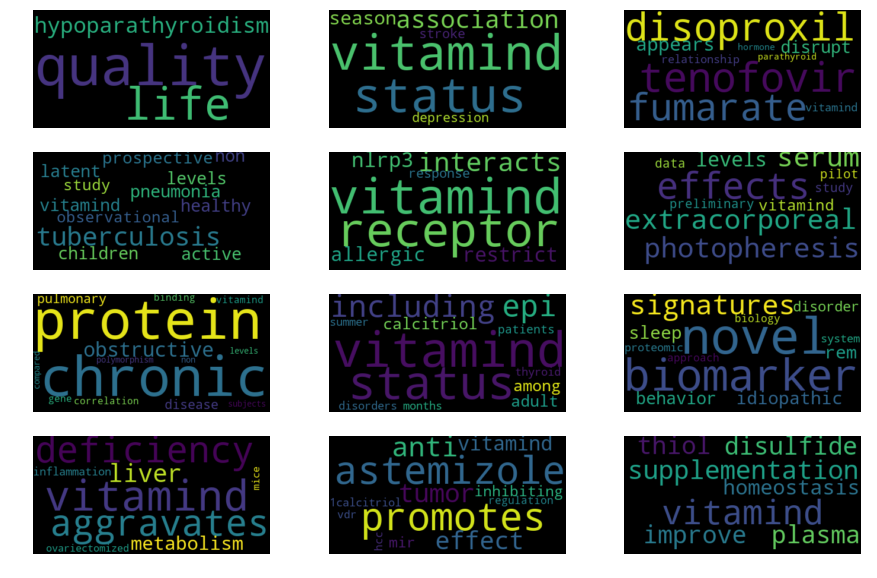

In [19]:
plt.figure(1, figsize=(15,10))

for entry in range(0,12):
    raw_str = titles.iloc[entry]
    wordcloud = WordCloud(max_words=1000,margin=0).generate(raw_str)
    
    plt.subplot(4,3, 1 + entry)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

plt.show()

The most used words of the headlines seem too detailed to be a topic.

In [20]:
titles = titles.str.split()

In [21]:
NUM_TOPICS_titles = 12

In [22]:
clean_titles = []

for entry in range(0,len(titles)):
    clean_titles.append([word for word in titles.iloc[entry] if word not in
                        STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}',
                                              word)])

In [23]:
titles_dictionary = corpora.Dictionary(clean_titles)
print(titles_dictionary)

Dictionary(41270 unique tokens: ['hypoparathyroidism', 'life', 'quality', 'association', 'depression']...)


In [24]:
titles_corpus = [titles_dictionary.doc2bow(text) for text in clean_titles]

In [25]:
# Build LDA model
lda_model = models.LdaModel(corpus=titles_corpus, num_topics=NUM_TOPICS_titles, 
                            id2word=titles_dictionary)

In [26]:
for idx in range(NUM_TOPICS_titles):
    print("Topics #%s:" % idx, lda_model.print_topic(idx, 3))

Topics #0: 0.040*"transport" + 0.028*"determination" + 0.026*"hypoparathyroidism"
Topics #1: 0.113*"bone" + 0.046*"metabolism" + 0.041*"calcium"
Topics #2: 0.061*"calcitriol" + 0.056*"rat" + 0.036*"intestinal"
Topics #3: 0.040*"vitamind" + 0.032*"receptor" + 0.028*"cells"
Topics #4: 0.035*"rickets" + 0.029*"osteomalacia" + 0.026*"vitamind"
Topics #5: 0.052*"action" + 0.022*"resorption" + 0.016*"vitamind"
Topics #6: 0.068*"renal" + 0.035*"treatment" + 0.029*"patients"
Topics #7: 0.081*"vitamind" + 0.049*"calcium" + 0.021*"dietary"
Topics #8: 0.032*"vitamind" + 0.032*"metabolites" + 0.030*"chick"
Topics #9: 0.030*"phosphate" + 0.027*"synthesis" + 0.021*"rats"
Topics #10: 0.069*"calcitriol" + 0.064*"serum" + 0.058*"parathyroid"
Topics #11: 0.062*"studies" + 0.038*"vitamind" + 0.024*"liver"


The topics for the headlines are more diverse and descriptive. 'Vitamin D and bones (e.g. osteoporosis, rickets)' is a big research topic, as well as 'kidneys and vitamin D' or 'vitamin D receptor mutations'. However, cancer and autoimmune diseases are missing.